# K-means

Author: Luke Moraglia

This notebook gives an overview of the K-means clustering algorithm and implements a `KMeans` instance from `scikit-learn`.

## Main idea
K-means is an unsupervised clustering algorithm that groups observations into $k$ clusters, with the goal of minimizing the within-cluster variance (sum of the squared Euclidean distances between the observations in a cluster). While a global minimal solution to this problem is computationally difficult, k-means can comparatively easily find a local minimum using an iterative process. The local minimum that the algorithm arrives at depends on the random starting conditions, so it is a good idea to run the algorithm several times with different starting conditions and then select the outcome with the minimum within-cluster variance. 

## Steps of the algorithm
K-means works by assigning observations to the nearest of $k$ centroids, which are the mean points of all observations in that group.
1. Initialize $k$ centroids in random starting positions. These are the initial conditions of the algorithm which can change with each run.
2. Iterate the following until there is no change in group membership or the max iterations are reached:
    1. Assign all observations to their nearest centroid.
    2. Recompute the location of all centroids using the set of observations that were assigned to each centroid.

Any new observations will be assigned to the nearest centroid. 

## (Re)Sources

- [Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)
- [Statquest](https://youtu.be/4b5d3muPQmA)
- [sklearn](https://scikit-learn.org/stable/modules/clustering.html#k-means)
- [ISLR](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf) ch 12, pg 517

# Library Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from helpers import cust_func

%matplotlib inline
#plt.rcParams['figure.figsize'] = [16, 9]
plt.style.use("fivethirtyeight")
%load_ext autoreload
%autoreload 2

# Load Data
The data we will use are the Wine data. The data consist of 178 wines from 3 classes, with measurements on 13 continuous variables.

In [2]:
wine_data = datasets.load_wine(as_frame=True)

In [3]:
X, y = wine_data.data, wine_data.target

In [4]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

# Implement `KMeans`
Here we create a `Pipeline` with a `MinMaxScaler` and `KMeans`. Since we know that there are 3 classes of wine in this data, we can select $k = 3$ (the `n_clusters` parameter), but in general you may not know the optimal value of $k$. It could be good to try out several $k$ values. 

## Function arguments to note
- n_clusters: this is $k$, the number of clusters to form.
- init: the way to initialize the starting centriods. 'random' gives random centroids. 'k-means++' (default) initializes centroids to be somewhat distant from each other.
- n_init: the number of times that K-means is run, each time with different starting seeds. The best of these runs, in terms of within-cluster variance is kept.
- random_state: make the results reproducible. 

In [6]:
steps = [("scaler", MinMaxScaler()), ("kmeans", KMeans(n_clusters = 3, random_state=42))]
kmeans_pipe = Pipeline(steps)
kmeans_pipe.fit(X)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

## PCA Visualization
We didn't use PCA to reduce the dimensionality of our data for KMeans clustering, but we can use it to visualize the 13-dimensional data in 2 dimensions. 

In [7]:
# PCA Pipeline
pca_steps = [('scaler', MinMaxScaler()), ('pca', PCA())]
pca_pipe = Pipeline(pca_steps)

In [8]:
fscores = pca_pipe.fit_transform(X)

In [9]:
# Percentage of variance explained by the first two components
round(sum(pca_pipe["pca"].explained_variance_ratio_[:2]), 3)

0.597

On the left we see the clusters that K-means assigned each observation. On the right are the true labels of the wines. There is decent agreement between the two, but not 100%.

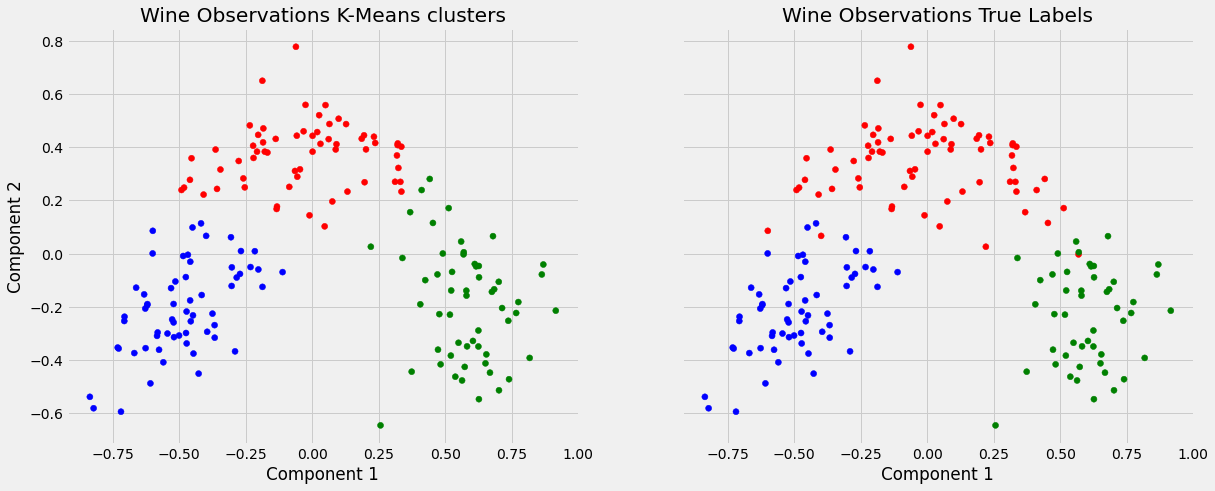

In [10]:
# Plot fscores for first two components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 12), sharey=True)
#plt.figure(figsize=(12, 12))
ax1.scatter(fscores[:, 0], fscores[:, 1],
            c=pd.Series(kmeans_pipe.predict(X)).map({0: "red", 1: "green", 2:"blue"}))
ax2.scatter(fscores[:, 0], fscores[:, 1],
            c=wine_data.target.map({0: "blue", 1: "red", 2:"green"}))

#ax = sc.axes
ax1.set_aspect('equal')
ax1.set_title("Wine Observations K-Means clusters")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")
ax2.set_aspect('equal')
ax2.set_title("Wine Observations True Labels")
ax2.set_xlabel("Component 1")

plt.show()